# Parametric modeling of coiled-coil regions of yeast Smc5/6
<br>

Tanmoy Sanyal<br>
Sali lab, UCSF

Necessary libraries:

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.PDB import PDBParser, PDBIO
from Bio.PDB import Model, Chain

from Bio import BiopythonWarning
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', BiopythonWarning)

import cc_utils as utils

FASTA file containing sequences:

In [5]:
FASTA_FN = os.path.abspath("../data/holocomplex.fasta.txt")

Output directories:

In [6]:
SMC5_DIR = "smc5"
SMC6_DIR = "smc6"

Avg. lengths of different coiled coil regions, obtained from preliminary (un-published) estimates from 2D-EM images.

In [7]:
MAXLEN_CC_HEAD = 8.6   # nm
MAXLEN_CC_HINGE = 10.8 #nm
MAXLEN_CC_MID = 14.7   #nm

Helper function to extract the specific sequence regions corresponding to the coiled-coil dimer from the fasta file. 

In [8]:
FASTA = {r.id: r.seq._data for r in SeqIO.parse(FASTA_FN, format="fasta")}

def _make_CC(protein_name, resrange1, resrange2):
    b1, e1 = resrange1
    seq1 = FASTA[protein_name][(b1-1): e1]
    
    b2, e2 = resrange2
    seq2 = FASTA[protein_name][(b2-1): e2]
    
    cc = (b1, e1, seq1), (b2, e2, seq2)
    
    s = """
%s
N-part: (%d, %d)
%s

C-part: (%d, %d)
%s
    """ % (protein_name,b1, e1, seq1, b2, e2, seq2)
    
    print(s)
    return cc

Helper function to rank alternate CC models:

In [9]:
def _rank_CC(model_dir, maxlen, verbose=False):
    # extract scores
    score_fn = os.path.join(model_dir, "scores.csv")
    df_score = pd.read_csv(score_fn)
    
    # display the scores
    if verbose:
        display(df_score)
    
    # get the XL satisfractions
    xl_viol = [(1-x) for x in df_score["frac_XL_sat"]]
    min_xl_viol = 0.0
    max_xl_viol = 1.0
    
    # get the lengths
    min_len = 1e6
    max_len = -999
    cc_len = []
    for i in range(len(df_score)):
        this_df = df_score.iloc[i]
        l1 = this_df["b1-e1"]
        l2 = this_df["b2-e2"]
        l3 = this_df["b1-b2"]
        l4 = this_df["e1-e2"]
        min_l = min(l1, l2, l3, l4)
        max_l = max(l1, l2, l3, l4)
        if min_l < min_len:
            min_len = min_l
        if max_l > max_len:
            max_len = max_l
        cc_len.append(0.25*(l1+l2+l3+l4))
    
    min_len = min(min_len, maxlen)
    max_len = max(max_len, maxlen)
    
    # plot the XL satisfaction and max length
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    
    ax.set_xlim([min_xl_viol, max_xl_viol])
    ax.set_ylim([0.98*min_len, 1.02 * max_len])

    ax.scatter(xl_viol, cc_len, c="blue", s=100)
    ax.axvline(0.1, color="k", ls="--", lw=2)
    ax.axhline(maxlen, color="k", ls="--", lw=2)

    ax.set_xlabel("(frac.) XL violation", fontsize=15)
    ax.set_ylabel("assembly length " + r"$(\AA)$", fontsize=15)   
    
    fig.tight_layout()
    plt.show()

## Smc5 head-adjacent coiled-coiled region (Smc5_cc-head) (Smc5:208-266, 885-946): Illustration of the workflow

![](images/cc_geometry.png)

In a nutshell, an antiparallel coiled-coil dimer (such as the parts of the Smc5/6 arm designed in this work) can be characterized by 9 parameters: register, radius ($R$), pitch($\lambda$) and the angle with the central axis ($\Delta \phi$ in the above figure) for each monomer, and the vertical distance between the two monomers($z$-shift). $R$, $\lambda$ and $z$ are geometrical paramters that are ideally sequence independent and are expected to be fairly similar across different geometry-based coiled-coil modeling softwares. In this work we use [ISAMBARD](https://github.com/isambard-uob/isambard), which is the parent framework for the more well known coiled-coil modeling program [CCBuilder2](http://coiledcoils.chm.bris.ac.uk/ccbuilder2/builder). However, ISAMBARD's API provides more fine-grained control on selecting good values of the geometrical parameters.<br>

Ranges for ($R_1,R_2$), ($\lambda_1, \lambda_2$), ($\phi_1, \phi_2$), and $z$ are chosen based on preliminary observations of the coiled-coil dimensions based on the negative staining 2D-EM images of the Smc5/6 arm, as well as from literature surveys of commonly observed values of these parameters in other coiled coils. Allowing these parameters to vary within the given ranges, ISAMBARD's genetic algorithm optimizer is used to obtain obtain 50 alternate models, while minimizing a molecular-mechanics forcefield based energy, such that the output models all have minimal steric straing and hence not merely ideal coiled coils.

Parameter search can be run using the ```generate_cc.py``` script kept in this directory. It needs mpi4py for distributed parallel runs. The shell script ```example_smc5_cc-head_job.sh``` can run this script for the smc5 cc-head region. The flag ```-h``` will give detailed usage information about the script.

The coiled-coil register (as denoted by the discrete positions a to f) for each monomer is *not* optimized by ISAMBARD. Prior to using ISAMBARD's parameter search, the best register arrangement for each monomer is found by converting the monomer sequence to a reduced alphabet (hydrophobic / polar i.e., HP alphabet) starting with one of the 6 candidate positions a to f for the first residue, and estimating what starting position assignment makes the HP version of the monomer sequence closest to an ideal heptad. This is automatically done by the ```generate.py``` script.<br>

![](smc5/example_cc-head/registers.png)
<br>

E.g. for smc5_cc_head, the best register for the starting residue of monomer-1 (N-terminal) is a while for monomer-2 (C terminal) "b" and "e" are equally likely. The rest of the parameter space is then explored with ISAMBARD, for both combinations (a,b) and (a,e), thus producing a total of 100 models.

Next, the models are ranked according to their crosslink satisfaction. Good scoring models are filtered and clustered to produce a single representative model that is passed on to the integrative modeling pipeline. 

In [10]:
cc = _make_CC("smc5", (208, 266), (885, 946))
model_dir = os.path.join(SMC5_DIR, "example_cc-head")


smc5
N-part: (208, 266)
LLDVLDELRELQGNEQSLQKDLDFKKAKIVHLRQESDKLRKSVESLRDFQNKKGEIELH

C-part: (885, 946)
SAVTILDQVTAELRELEHTVPQQSKDLETIKAKLKEDHAVLEPKLDDIVSKISARFARLFNN
    


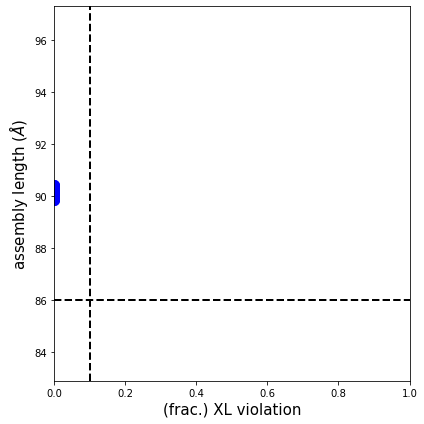

In [11]:
_rank_CC(model_dir=model_dir, maxlen=MAXLEN_CC_HEAD * 10.)

All models are in very close length range and have same XL satisfaction. So no filtering needed. The filtering function is run in dummy mode.

In [12]:
filtered_model_indices = utils.filter_models(score_fn=os.path.join(model_dir, "scores.csv"))
print("%d models after filtering" % len(filtered_model_indices))

clustfrac = utils.cluster(filtered_model_indices, model_dir=model_dir, 
                          param_fn=os.path.join(model_dir, "params.csv"),
                          score_fn = os.path.join(model_dir, "scores.csv"),
                          rmsd_cutoff=3.0, outdir=model_dir)

for k, v in clustfrac.items():
    print("cluster=%d, population=%.2f" % (k, v))

100 models after filtering
cluster=0, population=1.00


The centroid model for this cluster (which in this case, trivially contains all models) is saved as ```smc5/example_cc-head/cluster_0/cluster_center.pdb```.Here's what that looks like:
![](images/smc5_cc-head.png)
<br>

Smc5 is in coral, Smc6 in light blue. Satisfied and violated crosslinks are shown in blue and red respectively.<br>

XL satisfaction: 14/14, 100%<br>
9/9 DSSO, 5/5 CDI

For the other coiled-coil regions (except Smc5:304-363, 739-811, which is available from X-ray structure [3htk](https://www.rcsb.org/structure/3HTK)), the design process remains exactly the same as before. For each of these regions, only the corresponding ```cluster_center.pdb``` files for the top_cluster/(s) are saved in this directory.<br>

Further, some of them don't have good XL satisfaction because of one or two offending crosslinks. In such cases, we make minimal tweaks to the structure by deleting one or more residues (which can be later modelled as flexible beads during integrative modeling) on which such crosslinks are incident. This converts the over-length crosslinks from intra-rigid-body to inter-rigid-body during integrative modeling such that they be satisfied by configurational sampling.<br>

In the rest of this notebook, we'll record the structures of these separate coiled-coil regions and mention what, if any tweaks were made to the representative cluster center structure. The final structures are then saved in the ```best_models``` directory, and should be copied over to ```../data/pdb``` for integrative modeling.

## Smc5_cc-mid-1 (Smc5:272-302, 813-880)
This is the region between the head and the known (from xray structure 3htk) part of Smc5. All models have similar XL satisfaction and in the same length range. No filtering needed.

![](images/smc5_cc-mid-1-XL-violated.png)
<br>

XL satisfaction: 6/9, 66.67%<br>
2/5 DSSO, 4/4 CDI
<br>

Clearly the overshot part of the C-terminal part of this coil is not reliable. So, we forego the one satisfied XL towards the end of the C-terminal coil and delete the entire region between 813-850 to produce:<br>
![](images/smc5_cc-mid-1.png)
<br>

Now, XL satisfaction: 5/5, 100%<br>
2/2 DSSO, 3/3 CDI

## Smc5_cc-mid-2 (Smc5:365-388, 719-737)
This is the region between the known (3htk) part and the hinge region of Smc5. No filtering was required.

![](images/smc5_cc-mid-2.png)
<br>

XL satisfaction: 2/2, 100 %<br>
2/2 DSSO, 0/0 CDI

## Smc5_cc-hinge (Smc5:398-459, 653-714)
This is the coiled coil nearest to the hinge. No filtering was required.

![](images/smc5_cc-hinge-XL-violated.png)
<br>

XL satisfaction: 20/22, 90.9%<br>
16/16 DSSO, 4/6 CDI<br>

The 2 CDI violations are between (676, 697) and (675, 692). But there are lots of satisfied XLs incident on/from residues 675, 676 and 697. However, the part of the C-terminal coil from 675(ish)-697(ish) is clearly not rigid. To not lose most already satisfied XLs, the easiest option is to just delete the region 677-695, to produce: <br>

![](images/smc5_cc-hinge.png)
<br>

Now, XL satisfaction: 20/21 (95.2%)<br>
16/16 DSSO, 4/5 CDI

## Smc6_cc-head (Smc6:236-294, 923-984)
Region close to the head. No filtering done.

![](images/smc6_cc-head-XL_violated.png)<br>

XL satisfaction 1/2, 50%<br>
1/1 DSSO, 0/1 CDI.
<br>

The single violated CDI XL is between (943, 958). Adjusting this structure to get rid of the single violated XL may seem overkill, but prior experiments with XL data under -$\gamma$ATP conditions, shows that there are further XL violations in this region, further upstream. So, lets just treat this region as flexible and remove residues 940-950.<br>

![](images/smc6_cc-head.png)<br>

Now, XL satisfaction 1/1, 100%
1/1 DSSO, 0/0 CDI

## Smc6_cc-mid-1 (Smc6:298-310, 897-916)
No filtering was needed.

![](images/smc6_cc-mid-1.png)
<br>

XL satisfaction: 2/2, 100%
2/2 DSSO

## Smc6_cc-mid-2 (Smc6: 314-430, 769-882)
Theer were multiple clusters, and the most populated cluster was selected to supply rigid bodies.

![](images/smc6_cc-mid-2-XL-violated.png)<br>

XL satisfaction: 24/26, 92.3%<br>
18/19 DSSO, 6/7 CDI
<br>

There are two XLs violated. The least tedious way to (ever so slightly) improve this situation is to simply not include residue number 769.<br>

![](images/smc6_cc-mid-2.png)

## Smc6_cc-hinge (Smc6: 436-501, 699-760)
No filtering was required.

![](images/smc6_cc-hinge.png)
<br>

XL satisfaction: 14/14, 100%
10/10 DSSO, 4/4 CDI

# Total XL satisfaction
DSSO<br>
smc5: 9/9, 2/2, 8/8, 2/2, 16/16<br>
smc6: 1/1, 2/2, 18/19, 10/10<br>
overall: 68/69, 98.5%
<br><br>

CDI<br>
smc5: 5/5, 3/3, 3/3, 0/0, 4/5<br>
smc6: 0/1, 0/0, 6/6, 4/4<br>
overall: 25/27, 92.6%
<br><br>

Total<br>
smc5: 14/14, 5/5, 11/11, 2/2, 20/21<br>
smc6: 1/1, 2/2, 24/25, 14/14<br>
overall: 93/95, 97.89%
